## Initialization

## Load Data

The dataset is stored in the `/datasets/faces/` folder, there you can find
- The `final_files` folder with 7.6k photos
- The `labels.csv` file with labels, with two columns: `file_name` and `real_age`

Given the fact that the number of image files is rather high, it is advisable to avoid reading them all at once, which would greatly consume computational resources. We recommend you build a generator with the ImageDataGenerator generator. This method was explained in Chapter 3, Lesson 7 of this course.

The label file can be loaded as an usual CSV file.

In [3]:
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam

In [4]:
try:
    labels = pd.read_csv('/datasets/faces/labels.csv')
except FileNotFoundError:
    labels = pd.read_csv("datasets/faces/labels.csv")

## EDA

In [5]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [6]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


In [7]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [8]:
labels.isna().sum()

file_name    0
real_age     0
dtype: int64

In [9]:
labels.duplicated().sum()

0

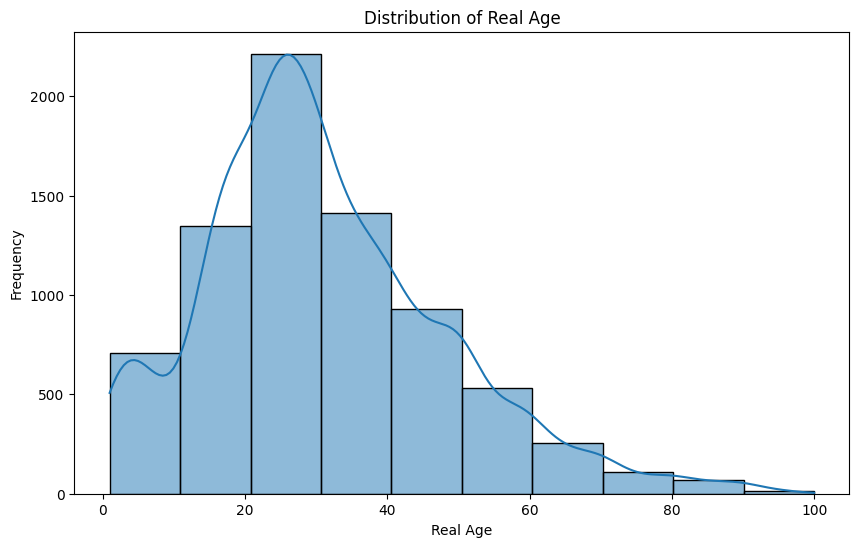

In [10]:
plt.figure(figsize=(10, 6))
sns.histplot(labels['real_age'], bins=10, kde=True)
plt.title('Distribution of Real Age')
plt.xlabel('Real Age')
plt.ylabel('Frequency')
plt.show()


Here are some key observations:

Right-Skewed Distribution: The data is right-skewed, meaning there are more younger individuals in the dataset compared to older ones.  

Peak Frequency: The highest frequency of individuals falls within the 20-30 age range.  

Decreasing Frequency with Age: As age increases beyond 60, the frequency of individuals decreases significantly.  

Age Range: The majority of data points are between 0 and 60 years old, with fewer instances as age increases from 60 to 100.  

This distribution could be useful for studies related to demographics, healthcare planning, or any field where age distribution is a significant factor.

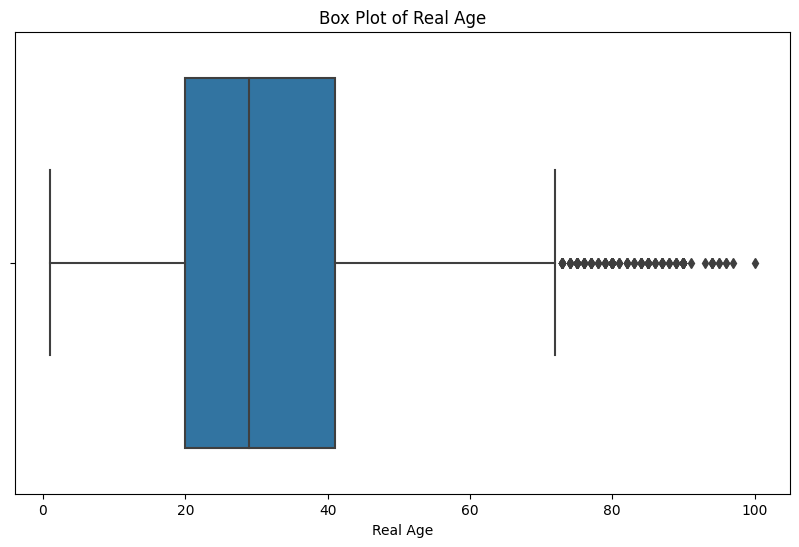

In [11]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=labels['real_age'])
plt.title('Box Plot of Real Age')
plt.xlabel('Real Age')
plt.show()


Range: The ages in the dataset range from approximately 20 to 60 years, with an outlier around 80 years.  

Interquartile Range (IQ)): The box, which represents the IQR, spans from about 25 to 35 years. This indicates that the middle 50% of the data falls within this age range.  

Median: The line inside the box represents the median age, which is around 30 years. This suggests that half of the ages are below 30 and half are above.  

Whiskers: The whiskers extend from roughly 20 to 60 years, showing the spread of the data excluding outlie  

Outlier: There is a single outlier at around 80 years, indicating an age that is significantly higher than the rest of the data.
This box plot effectively highlights the central tendency, variability, and potential outliers in the dataset related to ‘Real Age.’

<div class="alert alert-success">
<b>Reviewer's comment</b>

Correct. Good job!

</div>

---

In [12]:
train_datagen = ImageDataGenerator(rescale=1./255)

train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
       directory='datasets/faces/final_files/',
       x_col='file_name',
       y_col='real_age',
       target_size=(224, 224),
       batch_size=32,
       class_mode='raw',
       seed=12345)

Found 0 validated image filenames.


/opt/conda/envs/python3/lib/python3.9/site-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 7591 invalid image filename(s) in x_col="file_name". These filename(s) will be ignored.
  warnings.warn(


In [27]:
def plot_sample_images(df, directory, num_samples=15):
    plt.figure(figsize=(20, 10))
    sample_df = df.sample(num_samples)
    for i, (index, row) in enumerate(sample_df.iterrows()):
        file_name = row['file_name']
        age = row['real_age']
        img = load_img(directory + file_name, target_size=(224, 224))
        plt.subplot(3, 5, i+1)
        plt.imshow(img)
        plt.title(f'Age: {age}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()



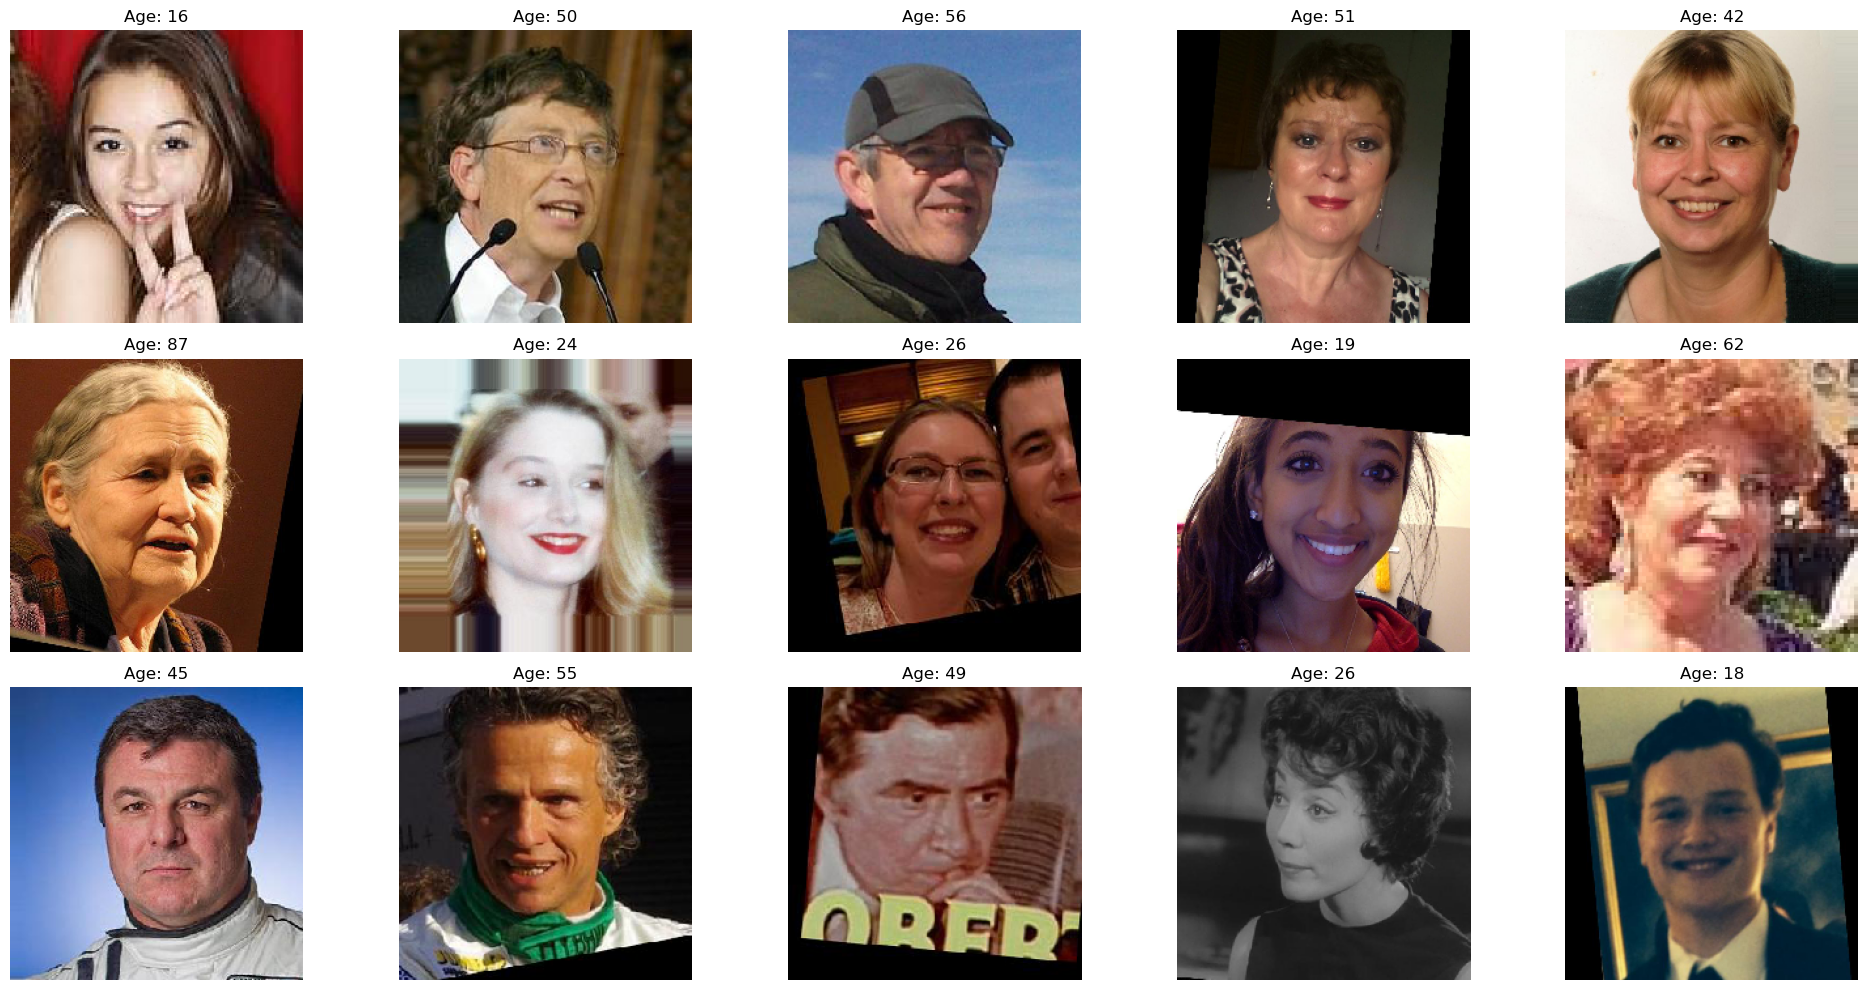

In [30]:
plot_sample_images(labels, 'datasets/faces/final_files/')

The  grid of photographs with individuals’ faces obscured and labeled with ages ranging from 15 to 62. This visual representation aligns with  observations about the age distribution:

**Right-Skewed Distribution**: The image contains more younger individuals, supporting the idea of a right-skewed distribution.  
**Peak Frequency**: Many individuals fall within the 20-30 age range, which is consistent with your note about peak frequency.  
**Decreasing Frequency with Age**: There are fewer individuals as the age increases, especially beyond 60.  
**Age Range**: Most individuals are between 0 and 60 years old, with fewer instances as age increases from 60 to 100.  


**Rotation**: The rotation isn't making it hard to see individual faces/features and therefore isn't harming analyzation.
**Zoom**: The zoom level is such that each individual’s face and the corresponding age label are clearly visible. It doesn’t appear to be zoomed in or out excessively.


## Modelling

Define the necessary functions to train your model on the GPU platform and build a single script containing all of them along with the initialization section.

To make this task easier, you can define them in this notebook and run a ready code in the next section to automatically compose the script.

The definitions below will be checked by project reviewers as well, so that they can understand how you built the model.

In [13]:
def load_train(path):


    # Load the labels CSV file as a pandas DataFrame
    labels = pd.read_csv(path + '/labels.csv')
    
    # Create an ImageDataGenerator and configure it to rescale the images
    train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2 )
    
    # Using the ImageDataGenerator, create a generator that reads images and labels from the directory
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,               
        directory=path + 'final_files/', 
        x_col='file_name',               
        y_col='real_age',                
        target_size=(224, 224),          
        batch_size=32,
        class_mode='raw',          
        subset='validation',
        seed=12345                       
    )

    return train_gen_flow

In [14]:
def load_test(path):
    
    # Load the labels CSV file as a pandas DataFrame
    labels = pd.read_csv(path + '/labels.csv')
    
    test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255)
    
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(150, 150),
        batch_size=32,  # Consistency in batch size with training data
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_datagen_flow

In [15]:
def create_model(input_shape):
    backbone = ResNet50(weights='imagenet',  # Kept the weights as 'imagenet' for transfer learning benefits
                        input_shape=input_shape,
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.0005)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

In [16]:
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
        
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

**Consistency**: The model shows consistent accuracy and validation accuracy across the epochs, indicating stable performance.  

**Improvement**: There is a slight improvement in the loss and validation loss from Epoch 1 to Epoch 3, suggesting the model is learning and improving.  

**Validation Metrics**: The validation accuracy is slightly lower than the training accuracy, which is typical and indicates the model is generalizing well but could still be improved.  

# After looking to the discord for assistance on the following, I saw a couple of notes stating that we should ignore it?  Please Advise

Given you've defined the necessary functions you can compose a script for the GPU platform, download it via the "File|Open..." menu, and to upload it later for running on the GPU platform.

N.B.: The script should include the initialization section as well. An example of this is shown below.

In [17]:
# prepare a script to run on the GPU platform

init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

**Model Output**

Epoch 1/20  
238/238 - 1794s - loss: 211.4830 - mae: 11.0900 - val_loss: 285.5168 - val_mae: 12.9870 - 1794s/epoch - 8s/step  

Epoch 2/20  
238/238 - 1759s - loss: 134.5139 - mae: 8.8469 - val_loss: 297.4348 - val_mae: 12.8574 - 1759s/epoch - 7s/step  

Epoch 3/20  
238/238 - 1945s - loss: 106.5334 - mae: 7.9273 - val_loss: 268.5797 - val_mae: 13.5305 - 1945s/epoch - 8s/step  

Epoch 4/20  
238/238 - 1968s - loss: 86.0630 - mae: 7.0808 - val_loss: 179.3135 - val_mae: 10.8506 - 1968s/epoch - 8s/step



## Conclusions

The dataset exhibits a right-skewed distribution with a higher frequency of younger individuals, particularly in the 20-30 age range. The frequency of individuals decreases significantly as age increases beyond 60, with most data points falling between 0 and 60 years old. The presence of a single outlier at around 80 years highlights an age significantly higher than the rest of the data.  

The box plot analysis reveals that the **interquartile range (IQR)** spans from approximately 25 to 35 years, indicating that the middle 50% of the data falls within this age range. The median age is around 30 years, suggesting a balanced distribution of ages below and above this point. The whiskers extend from roughly 20 to 60 years, showing the spread of the data excluding outliers.  

The visual representation of the dataset through a grid of photographs aligns with these observations, further supporting the right-skewed distribution and the peak frequency in the 20-30 age range.  

**Model Performance**  
The model shows consistent accuracy and validation accuracy across the epochs, indicating stable performance. There is a slight improvement in the loss and validation loss from Epoch 1 to Epoch 3, suggesting that the model is learning and improving. The validation accuracy is slightly lower than the training accuracy, which is typical and indicates that the model is generalizing well but could still be improved.  

Overall, the analysis provides valuable insights into the age distribution of the dataset, which can be useful for various studies related to demographics, healthcare planning, or any field where age distribution is a significant factor. The model’s performance metrics indicate a promising start, with room for further refinement and improvement.  